# Fine Tuning Transformer for MultiLabel Text Classification

### Introduction

In this tutorial we will be fine tuning a transformer model for the **Multilabel text classification** problem. 
This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one or more of categories out of the given list. For example a movie can be categorized into 1 or more genres.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data: 
	 - We are using the Jigsaw toxic data from [Kaggle](https://www.kaggle.com/)
     - This is competion provide the souce dataset [Toxic Comment Competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
	 - We are referring only to the first csv file from the data dump: `train.csv`
	 - There are rows of data.  Where each row has the following data-point: 
		 - Comment Text
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

Each comment can be marked for multiple categories. If the comment is `toxic` and `obscene`, then for both those headers the value will be `1` and for the others it will be `0`.


 - Language Model Used:
	 - BERT is used for this project. It was the transformer model created by the Google AI Team.  
	 - [Blog-Post](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)
	 - [Research Paper](https://arxiv.org/abs/1810.04805)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/bert.html)

---
***NOTE***
- *It is to be noted that the outputs to the BERT model are different from DistilBert Model implemented by the Hugging Face team. There are no `token_type_ids` generated from the tokenizer in case of Distilbert and also the final outputs from the network differ.*
- *This will be explained further in the notebook*
---

 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 


 - Script Objective:
	 - The objective of this script is to fine tune BERT to be able to label a comment  into the following categories:
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU. 

*I have included the code for TPU configuration, but commented it out. If you plan to use the TPU, please comment the GPU execution codes and uncomment the TPU ones to install the packages and define the device.*

In [1]:
# Installing the transformers library and additional libraries if looking process 

!pip install -q transformers

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 14.7MB/s 
     |████████████████████████████████| 1.1MB 28.3MB/s 
     |████████████████████████████████| 890kB 25.7MB/s 


In [2]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes. 
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* Import the file in a dataframe and give it the headers as per the documentation.
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [4]:
df = pd.read_csv("friends-personality.csv")
df['list'] = df[df.columns[4:]].values.tolist()
new_df = df[['text', 'character', 'list']].copy()
new_df.head()

,text,character,list
0,<b>s01_e01_c01(1) for Joey Tribbiani</b><br><b...,Joey Tribbiani,"[1, 1, 0, 0, 1]"
1,<b>s01_e01_c02(0) for Chandler Bing</b><br><br...,Chandler Bing,"[1, 0, 1, 1, 1]"
2,<b>s01_e01_c04(0) for Chandler Bing</b><br><br...,Chandler Bing,"[0, 0, 0, 0, 1]"
3,<b>s01_e01_c05(0) for Paul</b><br><br><b>Monic...,Paul,"[1, 0, 1, 1, 0]"
4,<b>s01_e01_c08(0) for Monica Geller</b><br><br...,Monica Geller,"[1, 0, 1, 1, 1]"


<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of CustomDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training. 
- We are using the BERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`
---
- *This is the first difference between the distilbert and bert, where the tokenizer generates the token_type_ids in case of Bert*
---
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)
- `targest` is the list of categories labled as `0` or `1` in the dataframe. 
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [5]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('/content/vocab (1).txt')

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [6]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [7]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (711, 3)
TRAIN Dataset: (569, 3)
TEST Dataset: (142, 3)


In [8]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`. 
 - This network will have the `Bert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.
 
#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`. 

In [9]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [10]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
    

In [11]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process. 

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.022 i.e. the network output is extremely close to the actual output.

In [12]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        #print(outputs, targets)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [13]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6958234310150146
Epoch: 1, Loss:  0.6865100860595703
Epoch: 2, Loss:  0.6772657632827759
Epoch: 3, Loss:  0.7048673033714294
Epoch: 4, Loss:  0.663170337677002
Epoch: 5, Loss:  0.6902519464492798
Epoch: 6, Loss:  0.6388057470321655
Epoch: 7, Loss:  0.55987948179245
Epoch: 8, Loss:  0.49685582518577576
Epoch: 9, Loss:  0.5309199690818787


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

In [14]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [15]:
for epoch in range(1):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs, normalize = True)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.04929577464788732
F1 Score (Micro) = 0.576923076923077
F1 Score (Macro) = 0.5618238634862577


In [ ]:
# ,cAGR,cCON,cEXT,cOPN,cNEU

In [35]:
matrix = metrics.multilabel_confusion_matrix(targets, outputs)
matrix

array([[[13, 59],
        [14, 56]],

       [[47, 40],
        [25, 30]],

       [[48, 27],
        [36, 31]],

       [[12, 36],
        [25, 69]],

       [[35, 44],
        [24, 39]]])

In [63]:
agr = [56,0,0,0,0]
con = [0,30,0,0,0]
ext = [0,0,31,0,0]
opn = [0,0,0,69,0]
neu = [0,0,0,0,39]

In [70]:

for i in range(len(outputs)):
    if (targets[i][3] == 1) and (outputs[i][0] == True and targets[i][0] == 0):
        opn[0]+=1
    elif (targets[i][3] == 1) and (outputs[i][4] == True and targets[i][4] == 0):
        opn[4]+=1
    elif (targets[i][3] == 1) and (outputs[i][1] == True and targets[i][1] == 0):
        opn[1]+=1
    elif (targets[i][3] == 1) and (outputs[i][2] == True and targets[i][2] == 0):
        opn[2]+=1

In [72]:
#pred  agr con ext opn neu
agr = [56, 19, 9, 7, 12]
con = [17, 30, 4, 5, 9]
ext = [22, 2, 31, 5, 16]
opn = [30, 7, 9, 69, 19]
neu = [22, 7, 8, 6, 39]

In [75]:
matrix = [agr, con, ext, opn, neu]
matrix


[[56, 19, 9, 7, 12],
 [17, 30, 4, 5, 9],
 [22, 2, 31, 5, 16],
 [30, 7, 9, 69, 19],
 [22, 7, 8, 6, 39]]

In [76]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

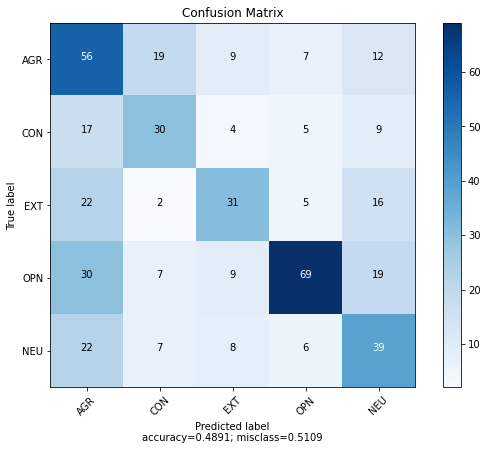

In [78]:
plot_confusion_matrix(cm           = np.array([[56, 19, 9, 7, 12],
                                                [17, 30, 4, 5, 9],
                                                [22, 2, 31, 5, 16],
                                                [30, 7, 9, 69, 19],
                                                [22, 7, 8, 6, 39]]), 
                      normalize    = False,
                      target_names = ['AGR', 'CON', 'EXT', 'OPN', 'NEU'],
                      title        = "Confusion Matrix")


In [ ]:
#Notas:

#Aqui pode-se perceber que o dataset precisa ser precisamente balanceado para fazer uma análise precisa dos resultados
#obtidos, uma vez que 1 fala pode representar 2 classes, e isto pode confundir a rede, então não é tão trivial fazer
#uma reflexão em cima de uma matrix de confusão, já que pode-se ter mais exemplos com 2 traços do que outros.

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training. 

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day. 

In [16]:
tokenizer.save_pretrained('./saved_model/')

('./saved_model/vocab.txt',
 './saved_model/special_tokens_map.json',
 './saved_model/added_tokens.json')

In [17]:
!zip -r saved_model.zip saved_model
files.download('saved_model.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/special_tokens_map.json (deflated 40%)
  adding: saved_model/tokenizer_config.json (stored 0%)
  adding: saved_model/vocab.txt (deflated 53%)


NameError: ignored